In [40]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /home/lnnersji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lnnersji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lnnersji/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/lnnersji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# I'm combining the training and testing data bc the algorithm I used splits it in a way I don't understand lol
df = pd.read_csv("train.tsv", header=None, sep="\t", names=[
    'ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Job', 'State', 'Party',
    'Barely True', 'False', 'Half True', 'Mostly True', 'Pants On Fire', 'Context'])
test_df = df = pd.read_csv("test.tsv", header=None, sep="\t", names=[
    'ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Job', 'State', 'Party',
    'Barely True', 'False', 'Half True', 'Mostly True', 'Pants On Fire', 'Context'])
df = pd.concat([df, test_df])
df = df.dropna()
df.head()

,ID,Label,Statement,Subject,Speaker,Job,State,Party,Barely True,False,Half True,Mostly True,Pants On Fire,Context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
6,7070.json,true,Says that Tennessee law requires that schools ...,"county-budget,county-government,education,taxes",stand-children-tennessee,Child and education advocacy organization.,Tennessee,none,0,0,0,0,0,in a post on Facebook.


In [5]:
# pre-processing statements for classification algorithms

corpus = df['Statement'].copy()  # sample list
vectorizer = TfidfVectorizer()
lemmatizer = WordNetLemmatizer()
corpus_normalized = []

# normalize the data
for s in corpus:
    s = re.sub(r'[^a-zA-Z\s]', ' ', s, re.I|re.A)  # remove special characters
    s = s.lower()  # switch to lowercase
    s = s.strip()
    tokens = word_tokenize(s)
    tokens_normalized = []
    for t in tokens:
        if t not in stopwords.words():
            tokens_normalized.append(lemmatizer.lemmatize(t, pos='v'))
    s = ' '.join(tokens_normalized)
    corpus_normalized.append(s)
    
target = []
for l in df['Label']:
    if l == 'pants-fire': target.append(0)
    elif l == 'false': target.append(1)
    elif l == 'barely-true': target.append(2)
    elif l == 'half-true': target.append(3)
    elif l == 'mostly-true': target.append(4)
    elif l == 'true': target.append(5)
    
# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(corpus_normalized,target,test_size=0.2)
    
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(corpus_normalized)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [16]:
# Naive Bayes Classification Algorithm
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  65.2046783625731


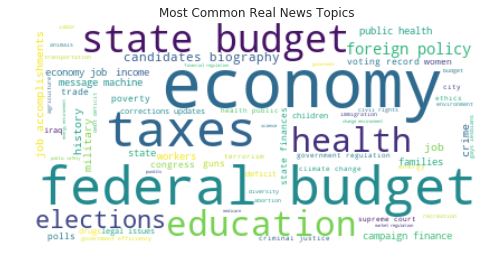

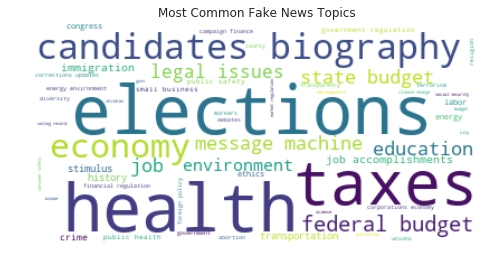

In [60]:
# Generate wordclouds for fake and real news topics
# getting topics from 'true' and 'mostly true' columns
is_true = df['Label'] == 'true'
real_subject = ' '.join(subjects.replace(',', ' ') for subjects in df[is_true]['Subject'])
is_true = df['Label'] == 'mostly-true'
real_subject2 = ' '.join(subjects.replace(',', ' ') for subjects in df[is_true]['Subject'])
real_subject = real_subject + real_subject2
real_wordcloud = WordCloud(stopwords=stopwords.words(), max_font_size=60, background_color="white").generate(real_subject)

# getting topics from 'pants fire' and 'false' columns
is_fake = df['Label'] == 'pants-fire'
fake_subject = ' '.join(subjects.replace(',', ' ') for subjects in df[is_fake]['Subject'])
is_fake = df['Label'] == 'false'
fake_subject2 = ' '.join(subjects.replace(',', ' ') for subjects in df[is_fake]['Subject'])
fake_subject = fake_subject + fake_subject2
fake_wordcloud = WordCloud(stopwords=stopwords.words(), max_font_size=60, background_color="white").generate(fake_subject)

plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Common Real News Topics')
plt.show()

plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Common Fake News Topics')
plt.show()

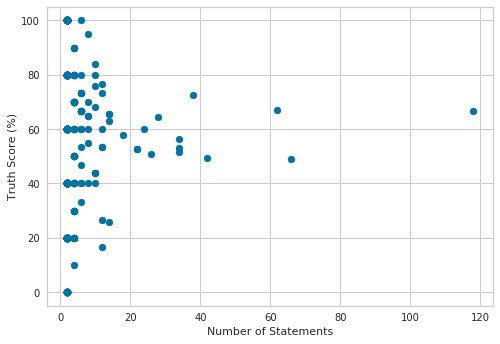

In [23]:
#  Truth breakdown of each speaker
list_speakers = list(dict.fromkeys(df['Speaker']))
x_data = []  # number of total statements
y_data = []  # truth score of each speaker

for s in list_speakers:
    is_s = df['Speaker'] == s
    
    score = 0
    total_score = 0
    count_statements = 0
    
    for l in df[is_s]['Label']:
        total_score = total_score + 5  # 
        count_statements = count_statements + 1
        
        if l == 'pants-fire': pass
        elif l == 'false': score = score + 1
        elif l == 'barely-true': score = score + 2
        elif l == 'half-true': score = score + 3
        elif l == 'mostly-true': score = score + 4
        elif l == 'true': score = score + 5
            
    x_data.append(count_statements)        
    truth_score = (score / total_score) * 100
    y_data.append(truth_score)
    
plt.scatter(x_data, y_data)
plt.xlabel('Number of Statements')
plt.ylabel('Truth Score (%)')
plt.show()